# Gabor Wavlet Bank, Feature Vector Calculations, and Image Reconstruction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tfl
import itertools
import os
from scipy.ndimage.interpolation import shift
from scipy.stats import pearsonr

## Gabor wavelet filter calculation, convolution, and reconstruction
* adapted MATLAB code from: https://visiome.neuroinf.jp/database/item/6894

In [2]:
class GaborWavelets:

    def __init__(self,params):
        self.params = params
        self.even_wavelets,self.odd_wavelets,self.wavelet_scales,self.wavelet_orientations,self.wavelet_locs = self._generateWaveletBank()
        self.wavelets = self.even_wavelets + self.odd_wavelets
        
        
    def _generateWaveletBank(self):
        params = self.params
        base_size_pix = params['base_size_pix']
        nScale = params['nScale']
        nOri = params['nOri']
        
        ### creation of wavelets
        even_wavelets = []
        odd_wavelets = []
        wavelet_scales = []
        wavelet_orientations = []
        wavelet_locs = []
        for s in range(nScale):

            filterSize = base_size_pix * 2**s  # number of pixels in filter size, incrementally increasing
            tx = ty = list(range(filterSize))
            X,Y = np.meshgrid(tx,ty)
            ctr = (base_size_pix)//2 # center location of wavelet

            for iO in range(nOri):
                # create wavelet of scale, s, orientation, iO, and phase even
                w_even,locs = self._createGaborWavelets(X,Y,s,ctr,iO,0)
                even_wavelets += w_even
                # create wavelet of scale, s, orientation, iO, and phase odd
                w_odd,_  = self._createGaborWavelets(X,Y,s,ctr,iO,1)
                odd_wavelets += w_odd

                nNewWavelets = len(w_even)
                wavelet_scales += [s] * nNewWavelets
                wavelet_orientations += [iO] * nNewWavelets
                wavelet_locs += locs

        print('Generated a bank of '+str(len(even_wavelets)+len(odd_wavelets))+' wavelets...')
        
        return even_wavelets,odd_wavelets,wavelet_scales,wavelet_orientations,wavelet_locs
        
    
    def _createGaborWavelets(self,X,Y,s,ctr,iOri,phase):
        sf = self.params['sf']
        theta0 = self.params['theta0']

        # create wavelet
        XX = sf * ((2**(-s) * X) - (ctr))
        YY = sf * ((2**(-s) * Y) - (ctr))
        rotX =  (XX * np.cos(iOri * theta0)) + (YY * np.sin(iOri * theta0))
        rotY = (-XX * np.sin(iOri * theta0)) + (YY * np.cos(iOri * theta0))
        base_wavelet = self._computeWavelet(rotX,rotY,phase)

        # downscale the wavlet values by the size of the wavelet so smaller 
        # wavelets are weighted the same as larger wavelets during convolution
        scaled_wavelet =  2**(-s) * base_wavelet

        # shift wavelet around frame to create more wavelets
        wavelets,locs = self._shiftWavelet(scaled_wavelet,s)

        return wavelets,locs


    def _computeWavelet(self,rotX,rotY,phase):
        phi = self.params['phi']
        kai = np.sqrt(2*np.log(2)) * (2**phi+1) / (2**phi-1)
        aspectRatio = self.params['aspectRatio']

        if phase == 0: # even (cos)
            tmpRes = np.multiply( 1/np.sqrt(2) * np.exp( -1/(2*aspectRatio**2) * (aspectRatio**2 * np.power(rotX,2) + np.power(rotY,2)) ), 
                                  ( np.exp(1j * kai * rotX) - np.exp(-kai**2/2) )
                                )
            res = np.real(tmpRes)
        elif phase == 1: # odd (sin)
            tmpRes = np.multiply( 1/np.sqrt(2) * np.exp( -1/(2*aspectRatio**2) * (aspectRatio**2 * np.power(rotX,2) + np.power(rotY,2)) ), 
                          ( np.exp(1j * kai * rotX) )
                        )
            res = np.imag(tmpRes)
        else:
            raise ValueError('Phase must be 0 (even) or 1 (odd). This is hard-coded, so this error should never be raised.')

        return res


    def _shiftWavelet(self,w,s):
        conv_grid_sizes = self.params['conv_grid_sizes']
        image_size = self.params['image_size']

        # define all locations to place filter
        grid_size = conv_grid_sizes[s] # number of locations depends on scaling factor
        grid_steps = np.linspace(0,image_size[0],grid_size)
        locs = list(itertools.product(grid_steps,repeat=2))

        # define centers of wavelets and image frame to find shift values
        w_ctr = w.shape[0]//2
        im_ctr = image_size[0]//2
        shift_to_center = im_ctr - w_ctr
        if len(locs) == 1: # if one location, just place in center of image frame
            locs[0] = (im_ctr,im_ctr)

        w_locs = []
        # calculate filter at different locations for same size as the original image
        if w.shape[0] <= image_size[0]: # if filter is smaller than or same size as image
            for loc in locs:
                # center image on a frame
                frame = np.zeros(image_size)
                frame[shift_to_center:shift_to_center+w.shape[0],
                      shift_to_center:shift_to_center+w.shape[1]] = w
                # calculate location offsets from center of frame
                offset = np.array(np.asarray(loc)-im_ctr,dtype=int)
                # shift image by location offsets
                frame_shifted = shift(frame,offset)
                w_locs.append(frame_shifted)
        else: # if filter is larger than image
            for loc in locs: 
                scale_diff = w_ctr//im_ctr
                # calculate location offsets from center of frame
                offset = np.array((np.asarray(loc) * scale_diff)-w_ctr,dtype=int)
                # shift image on temp frame by location offsets
                tempframe_shifted = shift(w,offset)
                # center image on a frame
                frame = np.zeros(image_size)
                frame_shifted = tempframe_shifted[(-1*shift_to_center):(-1*shift_to_center)+image_size[0],
                                                  (-1*shift_to_center):(-1*shift_to_center)+image_size[1]]
                w_locs.append(frame_shifted)

        return w_locs,locs


    def saveWaveletImages(self,save_path):
        even_wavelets = self.even_wavelets
        odd_wavelets = self.odd_wavelets
        wavelet_scales = self.wavelet_scales
        wavelet_orientations = self.wavelet_orientations
        wavelet_locs = self.wavelet_locs
        
        # create save location if it does not exist
        if not os.path.exists(save_path):
            os.makedirs(save_path, exist_ok=True)
        
        # save each wavelet image with name specifying parameters
        base_pix = self.params['base_size_pix']
        for iW in range(len(even_wavelets)):
            size = str(int(base_pix * 2**wavelet_scales[iW]))
            ori = str(wavelet_orientations[iW])
            ctrX = str(int(wavelet_locs[iW][0]))
            ctrY = str(int(wavelet_locs[iW][1]))
            save_str_append = '_size'+size+'pix_ori'+ori+'_loc_x'+ctrX+'_y'+ctrY+'.tif'

            tfl.imsave(os.path.join(save_path,'wavelet_phaseEVEN'+save_str_append),even_wavelets[iW])
            tfl.imsave(os.path.join(save_path,'wavelet_phaseODD' +save_str_append),odd_wavelets[iW])

        print('Wavelets saved at: '+save_path)

In [12]:
class FeatureVectors:
    
    def __init__(self,wavelets,im):
        self.wavelets = wavelets
        self.im = im
        self.G_fwd,self.G_rev = self._createTransformationMatrices()
        
        
    def _createTransformationMatrices(self):
        wavelets = self.wavelets
        
        # create convolution matrix to transform image to feature vector
        # shape of G_fwd = (nFeatures,nPixels)
        G_fwd = np.asarray(wavelets)
        G_fwd = G_fwd.reshape((G_fwd.shape[0],G_fwd.shape[1]*G_fwd.shape[2]))
        
        # shape of G_rev = (nPixels,nFeatures)
        G_rev = G_fwd.transpose()
        
        return G_fwd,G_rev
        
        
    def image2features(self,feature_tile_repeats_for_save=1,save_path=None):
        '''convolve images, extract feature vectors'''
        wavelets = self.wavelets
        im = self.im
        
        # shape of G_fwd = (nFeatures,nPixels)
        G_fwd = self.G_fwd 

        # shape of im_vector = (nPixel,nFrames)
        im_vector = im.reshape((im.shape[0]*im.shape[1],im.shape[2]))

        # shape of feature_vector = (nFeatures,nFrames)
        feature_vector = G_fwd @ im_vector

        # normalize feature values between [-1,1]
        min_val = feature_vector.min()
        max_val = feature_vector.max()
        abs_max = np.max((np.abs(min_val),np.abs(max_val)))
        feature_vector_norm = ((feature_vector+abs_max)/abs_max) - 1
        
        # save feature_vector_norm as .npz
        if save_path is not None:
            # tile feature_vector_norm for number of movie repeats
            if feature_tile_repeats_for_save > 1:
                feature_vector_tiled = np.tile(feature_vector_norm,feature_tile_repeats_for_save)
            else:
                feature_vector_tiled = feature_vector_norm
            print('Shape of saved feature vector array: ',feature_vector_tiled.shape)
            
            # create save location if it does not exist
            if not os.path.exists(save_path):
                os.makedirs(save_path, exist_ok=True)
            
            save_name = os.path.join(save_path,'feature_vectors.npz')
            np.savez(save_name,feature_vectors=feature_vector_tiled)
            print('Feature vector array saved at: ',save_name)
        
        return feature_vector_norm
    
    
    def features2image(self,feature_vector_norm,save_path=None):
        '''reconstruct image using feature_vector and Gabor wavelet filters'''
        im = self.im
        
        # shape of G_rev = (nPixels,nFeatures)
        G_rev = self.G_rev
        
        # recon_im_vector.shape = (nPixels,nFrames)
        recon_im_vector = G_rev @ feature_vector_norm
        reconstructed_im = recon_im_vector.reshape(im.shape)
        min_val = reconstructed_im.min()
        max_val = reconstructed_im.max()

        # save reconstructed frames
        if save_path is not None:
            # create save location if it does not exist
            if not os.path.exists(save_path):
                os.makedirs(save_path, exist_ok=True)
            
            # shift axes for .tif comptability
            re_im = np.rollaxis(reconstructed_im,2,0)
            
            save_name = os.path.join(save_path,'reconstructed_movie.tif')
            tfl.imsave(save_name,re_im,bigtiff=True)
            print('Reconstructed movie saved at: ',save_name)
        
        return reconstructed_im
    
    
    def testReconstructionAccuracy(self,reconstructed_im,frame_idx=0):
        # test reconstructed images
        print('Testing correlation of frame: '+str(frame_idx))
        
        im = self.im

        plt.figure()
        plt.imshow(im[:,:,frame_idx])
        plt.title('Original Image')

        plt.figure()
        plt.imshow(reconstructed_im[:,:,frame_idx])
        plt.title('Reconstructed Image')

        # test correlation between original image and reconstructed image
        r,pval = pearsonr(im[:,:,frame_idx].flatten(),reconstructed_im[:,:,frame_idx].flatten())
        print('Correlation coefficient: ',r)
        print('p-value: ',pval)

In [14]:
### save parameters
save_path = './data/'
movie_repeats = 60

### image parameters
im = tfl.imread('./data/processed_movie.tif')
im = np.rollaxis(im,0,3) # make last dimension the frames
image_size = im[:,:,0].shape

### Gabor wavelet parameters
nScale = 4                   # number of different scales (mults of 2), scale factors, s = list(range(nScales))
nOri = 4                     # number of sampling orientations
base_size_pix = 8            # minimum size of wavelet filter in pixels (scale size factor, s, of 0)
sf = 4/base_size_pix         # scaling factor
conv_grid_sizes = [11,5,3,1] # specify grid sizes for centering wavelets for convolution (eg. 5 means a 5x5 grid with 25 centers)
phi = 1.5                    # bandwidth of gabor
aspectRatio = 1              # aspect ratio of gabor filter (applied to x dimension, relative to y dimension)
theta0 = np.pi/nOri          # step size of angular rotations

assert len(conv_grid_sizes) == nScale, 'Must specify a number of grid locations to apply filter for each scale'

# parameter dictionary
params = {
    'image_size': image_size,
    'phi': phi,
    'aspectRatio': aspectRatio,
    'base_size_pix': base_size_pix,
    'sf': sf,
    'nScale': nScale,
    'nOri': nOri,
    'theta0': theta0,
    'conv_grid_sizes': conv_grid_sizes
}

# create wavelets with above parameters and save
GW = GaborWavelets(params)

# output location for wavelets
save_path_wavelets = os.path.join(save_path,'wavelets/')
GW.saveWaveletImages(save_path_wavelets)

# create transformations for image->feature vector and vice-versa
FV = FeatureVectors(GW.wavelets,im)
feature_vector = FV.image2features(movie_repeats,save_path)
reconstructed_im = FV.features2image(feature_vector,save_path)

Generated a bank of 1248 wavelets...
Wavelets saved at: ./data/wavelets/
Shape of saved feature vector array:  (1248, 36000)
Feature vector array saved at:  ./data/feature_vectors.npz
Reconstructed movie saved at:  ./data/reconstructed_movie.tif


Testing correlation of frame: 500
Correlation coefficient:  0.9028745967273869
p-value:  0.0


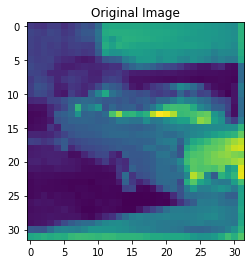

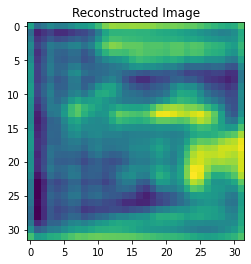

In [17]:
# test reconstruction accuracy
FV.testReconstructionAccuracy(reconstructed_im,frame_idx=500)